# ETL Data Cleanup and Feature Engineering

In [13]:
import numpy as np               # Array, Vector, matrix calculations
import pandas as pd              # DataFrame handling
import matplotlib.pyplot as plt  # Plotting
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn import preprocessing
from matplotlib import pyplot
pd.options.display.max_columns = 999

%matploblib inline
np.random.seed(42)               # Answer to everything

UsageError: Line magic function `%matploblib` not found.


In [21]:
# Import file
path = 'D:/Python/Projects/02_GSC/cs-training.csv'
data = pd.read_csv(path,
                  usecols = ['SeriousDlqin2yrs',
                             'RevolvingUtilizationOfUnsecuredLines',
                             'age',
                             'NumberOfTime30-59DaysPastDueNotWorse',
                             'DebtRatio',
                             'MonthlyIncome',
                             'NumberOfOpenCreditLinesAndLoans',
                             'NumberOfTimes90DaysLate',
                             'NumberRealEstateLoansOrLines',
                             'NumberOfTime60-89DaysPastDueNotWorse',
                             'NumberOfDependents'])

## Null treatment

Identify clear Nan Values, replace with median. Median preferred due to robustness on data, and feasible value.

data.isna().sum() # Diagnose Dataframe

In [22]:
# Create Boolean Features
data['MonthlyIncome_na'] = data['MonthlyIncome'].isna()
data['NumberOfDependents_na'] = data['MonthlyIncome'].isna()

# Input median on problem features
data['MonthlyIncome'] = data['MonthlyIncome'].fillna(data['MonthlyIncome'].median())
data['NumberOfDependents'] = data['NumberOfDependents'].fillna(data['NumberOfDependents'].median())

# Check data
data.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
MonthlyIncome_na                        0
NumberOfDependents_na                   0
dtype: int64

## Outlier treatment
We need the bins, previously defined in EDA notebook we will use this bins to encode outlier features
- **RevolvingUtilizationOfUnsecuredLines:** [0, 0.029867442, 0.154180737, 0.5590462475, 1.35281445575, 2.146582664, inf]
- **Age:** [0, 18, 20, 41, 52, 63, 80, 93, float('Inf')] 
- **NumberOfTime30-59DaysPastDueNotWorse:** [0, 0.99, 1, 2, 4, 6, 10, 13, float('Inf')]
- **DebtRatio:** [-inf, -1.9044659907499997, -0.8646960792499998, 0.17507383225, 0.366507841, 0.86825377325, 1.9080236847499998, 2.9477935962499995, inf]
- **MonthlyIncome:** [float('-Inf'), 0, 3400, 5400, 8000, 10000, 15000, 20000, 23000, float('Inf')]
- **NumberOfOpenCreditLinesAndLoans**: [float('-inf'), 0, 5, 8, 11, 20, 29, float('inf')]
- **NumberOfTimes90DaysLate:** [float('-inf'), 0, 1, 2, 3, 8, 10, float('inf')]
- **NumberOfTime60-89DaysPastDueNotWorse:** bins = [float('-inf'), 0, 1, 2, 3, float('inf')]

In [23]:
# Encode Outliers
data['RevolvingUtilizationOfUnsecuredLines_out'] = np.where(data['RevolvingUtilizationOfUnsecuredLines']>=2.14, 1, 0)
data['age_out'] = np.where(data['age'] >= 90, 1, 0)
data['NumberOfTime30-59DaysPastDueNotWorse_out'] = np.where(data['NumberOfTime30-59DaysPastDueNotWorse'] > 13, 1, 0)
data['DebtRatio_out'] = np.where(data['DebtRatio'] > 2.94, 1, 0)
data['MonthlyIncome_out'] = np.where(data['MonthlyIncome'] > 23000, 1, 0)
data['NumberOfOpenCreditLinesAndLoans_out'] = np.where(data['NumberOfOpenCreditLinesAndLoans'] > 20, 1, 0)
data['NumberOfTimes90DaysLate_out'] = np.where(data['NumberOfTimes90DaysLate'] > 10, 1, 0)
data['NumberOfTime60-89DaysPastDueNotWorse_out'] = np.where(data['NumberOfTime60-89DaysPastDueNotWorse'] > 3, 1, 0)


## Data Standarization without Outliers

In [26]:
# Remove Outliers from Data
data['RevolvingUtilizationOfUnsecuredLines'] = np.where(data['RevolvingUtilizationOfUnsecuredLines_out']>=2.14, 2.14, data['RevolvingUtilizationOfUnsecuredLines'])
data['age'] = np.where(data['age_out'] >= 90, 90, data['age'])
data['NumberOfTime30-59DaysPastDueNotWorse'] = np.where(data['NumberOfTime30-59DaysPastDueNotWorse_out'] > 13, 13, data['NumberOfTime30-59DaysPastDueNotWorse'])
data['DebtRatio'] = np.where(data['DebtRatio_out'] > 2.94, 2.94, data['DebtRatio'])
data['MonthlyIncome'] = np.where(data['MonthlyIncome_out'] > 23000, 23000, data['MonthlyIncome'])
data['NumberOfOpenCreditLinesAndLoans'] = np.where(data['NumberOfOpenCreditLinesAndLoans_out'] > 20, 20, data['NumberOfOpenCreditLinesAndLoans'])
data['NumberOfTimes90DaysLate'] = np.where(data['NumberOfTimes90DaysLate'] > 10, 10, data['NumberOfTimes90DaysLate'])
data['NumberOfTime60-89DaysPastDueNotWorse'] = np.where(data['NumberOfTime60-89DaysPastDueNotWorse'] > 3, 3, data['NumberOfTime60-89DaysPastDueNotWorse'])
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_na,NumberOfDependents_na,RevolvingUtilizationOfUnsecuredLines_out,age_out,NumberOfTime30-59DaysPastDueNotWorse_out,DebtRatio_out,MonthlyIncome_out,NumberOfOpenCreditLinesAndLoans_out,NumberOfTimes90DaysLate_out,NumberOfTime60-89DaysPastDueNotWorse_out
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,False,False,0,0,0,0,0,0,0,0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,False,False,0,0,0,0,0,0,0,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,False,False,0,0,0,0,0,0,0,0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,False,False,0,0,0,0,0,0,0,0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,False,False,0,0,0,0,1,0,0,0


# Model Training
We are facing a Classification Problem, our target is to define the probability of an event of delinquency in the next 2 years. As a primer we will fit a random forest model to test the performance of our features.

## Train Test Split to avoid Leakage

In [34]:
X = data[['RevolvingUtilizationOfUnsecuredLines',
          'age',
          'NumberOfTime30-59DaysPastDueNotWorse',
          'DebtRatio',
          'MonthlyIncome',
          'NumberOfOpenCreditLinesAndLoans',
          'NumberOfTimes90DaysLate',
          'NumberOfTime60-89DaysPastDueNotWorse',
          'NumberOfDependents'

          ]]

In [35]:
y = data['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

## Model training

In [36]:
names = X.columns
scaler = preprocessing.StandardScaler()


# Model without Outlier features
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

## Performance metrics

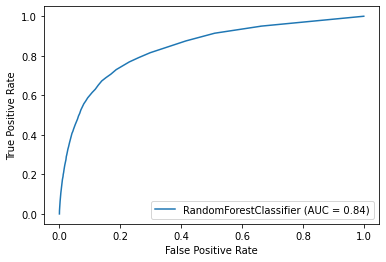

In [37]:
#X_train = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns=names)

rfc_disp = plot_roc_curve(rfc, X_test, y_test)

Feature: 0, Score: 0.20007
Feature: 1, Score: 0.12988
Feature: 2, Score: 0.04972
Feature: 3, Score: 0.19124
Feature: 4, Score: 0.15445
Feature: 5, Score: 0.09045
Feature: 6, Score: 0.09124
Feature: 7, Score: 0.05009
Feature: 8, Score: 0.04288


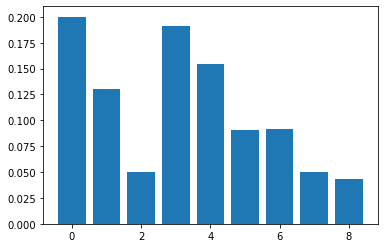

In [38]:
## Variable Importance
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [39]:
feature_imp = pd.Series(rfc.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

RevolvingUtilizationOfUnsecuredLines    0.200069
DebtRatio                               0.191242
MonthlyIncome                           0.154445
age                                     0.129877
NumberOfTimes90DaysLate                 0.091236
NumberOfOpenCreditLinesAndLoans         0.090448
NumberOfTime60-89DaysPastDueNotWorse    0.050085
NumberOfTime30-59DaysPastDueNotWorse    0.049717
NumberOfDependents                      0.042881
dtype: float64

No handles with labels found to put in legend.


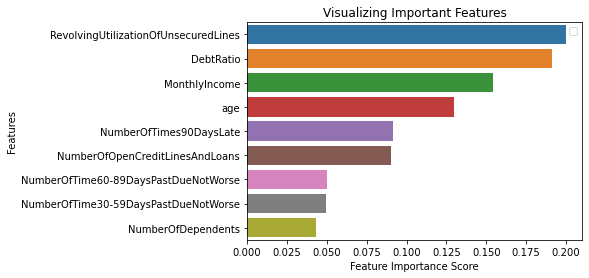

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()